In [1]:
import numpy as np
import keras
import tensorflow
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D
from keras.datasets import cifar10
from keras.applications.mobilenet import MobileNet
from keras.utils import np_utils
import matplotlib.pyplot as plt


%matplotlib inline

Using TensorFlow backend.


## Load Data: (32,32,3) Images

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

[7]


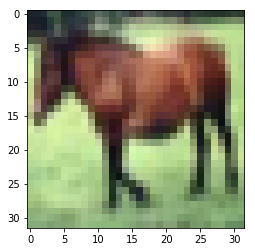

In [3]:
print(y_train[7])   #Convince yourself that the labels are consistent with the data.  See https://www.cs.toronto.edu/~kriz/cifar.html
plt.imshow(x_train[7,:,:,:])

## Clean Data:  Binary Reps. of Categories, Unrolling, Scaling

In [4]:
x_train_unrolled = x_train.reshape(-1,32*32*3) / 256
print(x_train_unrolled.shape)
y_train_encoded = np_utils.to_categorical(y_train)

x_test_unrolled = x_test.reshape(-1,32*32*3) / 256
y_test_encoded = np_utils.to_categorical(y_test)

(50000, 3072)


## Create Unbiased Conv. NN

In [23]:
fresh = MobileNet(include_top = False, weights=None)
fresh.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (Activation)      (None, None, None, 32)    0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
__________

## Add Adapters for Data Dimensions

In [24]:
#Documentation for MobileNet says smaller shapes allowed, but throws error.  https://keras.io/applications/#mobilenet
#Thus, we have to adapt a new model to take the dimensions of our data.
#Initializing w/ input_shape will create input layer which we will later remove.  

rand_init_model = Sequential()

rand_init_model.add(Dense(64,input_dim=(32*32*3), activation = 'sigmoid',name='cifar10_in_adapter'))
rand_init_model.layers.extend(fresh.layers)
rand_init_model.add(Dense(10,activation = 'softmax', name='cifar10_class_adapter'))

rand_init_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])





## Fit and Plot

In [25]:
%%time
history_fresh = rand_init_model.fit(x_train_unrolled,y_train_encoded, epochs=50)

Epoch 1/50
50000/50000 [==============================] - 13s 253us/step - loss: 1.9408 - acc: 0.3123
Epoch 2/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.7822 - acc: 0.3718
Epoch 3/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.7248 - acc: 0.3894
Epoch 4/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.6873 - acc: 0.4005
Epoch 5/50
50000/50000 [==============================] - 17s 344us/step - loss: 1.6618 - acc: 0.4101
Epoch 6/50
50000/50000 [==============================] - 13s 253us/step - loss: 1.6337 - acc: 0.4200
Epoch 7/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.6211 - acc: 0.4258
Epoch 8/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.6060 - acc: 0.4283
Epoch 9/50
50000/50000 [==============================] - 10s 204us/step - loss: 1.5889 - acc: 0.4342
Epoch 10/50
50000/50000 [==============================] - 11s 212us/step - loss: 

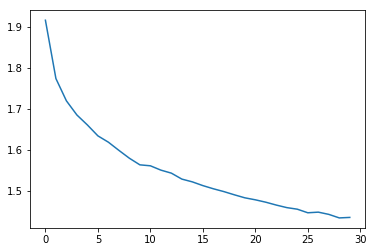

In [12]:
plt.plot(history_fresh.history['loss'])
#plt.plot(history_fresh.history['acc'])

## Create Biased Conv. NN

In [18]:

trained_model = MobileNet(input_shape = (128,128,3),include_top = False, weights='imagenet')

#Freeze: keep some pre-trained weights as they are.
#Try freezing other layers.
for layer in trained_model.layers:
    layer.trainable = False

#Check number of trainable parameters after freezing layers.
trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 130, 130, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 66, 66, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
__________

In [19]:
#Create new model to add the trained model into.  
transfer_model = Sequential()
transfer_model.add(Dense(64,input_dim=(32*32*3), activation = 'sigmoid',name='cifar10_in_adapter'))
    
    
#Extend list of layers to include layers of trained_model.
#Check summary on model to see the layer structures.
#Remember, include_top = False has already chopped off the classification layers.
transfer_model.layers.extend(trained_model.layers)
transfer_model.add(Dense(10, activation = 'softmax', name = 'cifar10_class_adapter'))

#Experiment: freeze all trainable params.  What do you expect to happen to the acc?  Check summary.
#transfer_model.trainable = False  


transfer_model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])


In [20]:
#transfer_model.summary()

## Fit

In [21]:
%%time
history_transfer = transfer_model.fit(x_train_unrolled,y_train_encoded,epochs=50)

Epoch 1/50
50000/50000 [==============================] - 11s 220us/step - loss: 1.9510 - acc: 0.3043
Epoch 2/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.7988 - acc: 0.3615
Epoch 3/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.7327 - acc: 0.3859
Epoch 4/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.6924 - acc: 0.4002
Epoch 5/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.6575 - acc: 0.4103
Epoch 6/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.6370 - acc: 0.4176
Epoch 7/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.6158 - acc: 0.4261
Epoch 8/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.6051 - acc: 0.4286
Epoch 9/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.5928 - acc: 0.4351
Epoch 10/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.5779 

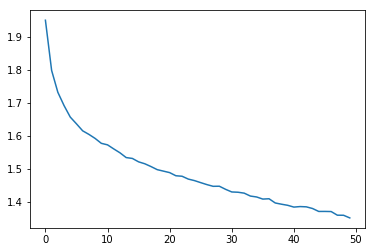

In [22]:
plt.plot(history_transfer.history['loss'])

## Prediction and Scoring

In [26]:
unbiased_prediction = rand_init_model.predict_proba(x_test_unrolled)

In [27]:
biased_prediction = transfer_model.predict_proba(x_test_unrolled)

In [28]:
#Unbiased
#Brier score, lower is better.  Try looking at prediction scores before and after training.
unbiased_diff = y_test_encoded - unbiased_prediction
score_u = np.sum((1/10)*(np.power(unbiased_diff,2)),axis=1)

#Overall score for 10000 test examples.
sum(score_u)

683.75656603251741

In [29]:
#Biased
biased_diff = y_test_encoded - biased_prediction  
score_b = np.sum((1/10)*(np.power(biased_diff,2)),axis=1)

sum(score_b)

687.58190690675394